In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:
train_deterministic = True # train a deterministic model as starting point 

In [3]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [4]:
device

device(type='cuda')

In [5]:
# prepare data
data_dir = "./data"
fig_dir = "./figs"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #
if train_deterministic:
    num_epochs = 10
    base_model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

    loss_list, acc_list, ece_list = [[] for _ in range(3)]
    for epoch in range(num_epochs):
        base_model.train()
        batch_loss = []
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = base_model(img)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        avg_loss = sum(batch_loss)/len(batch_loss)
        base_acc = compute_accuracy(base_model, testloader, device=device)
        base_ece = compute_ece_loss(base_model, testloader, device=device)
        print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
        loss_list.append(avg_loss)
        acc_list.append(base_acc)
        ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 1.7485 Acc 0.6496 ECE 0.0228
Base Model Epoch 1 Avg Loss 0.7392 Acc 0.7427 ECE 0.0120
Base Model Epoch 2 Avg Loss 0.6278 Acc 0.7682 ECE 0.0103
Base Model Epoch 3 Avg Loss 0.5596 Acc 0.7823 ECE 0.0162
Base Model Epoch 4 Avg Loss 0.5181 Acc 0.8093 ECE 0.0126
Base Model Epoch 5 Avg Loss 0.4784 Acc 0.8070 ECE 0.0090
Base Model Epoch 6 Avg Loss 0.4566 Acc 0.8267 ECE 0.0105
Base Model Epoch 7 Avg Loss 0.4342 Acc 0.8347 ECE 0.0148
Base Model Epoch 8 Avg Loss 0.4142 Acc 0.8324 ECE 0.0133
Base Model Epoch 9 Avg Loss 0.3969 Acc 0.8506 ECE 0.0097


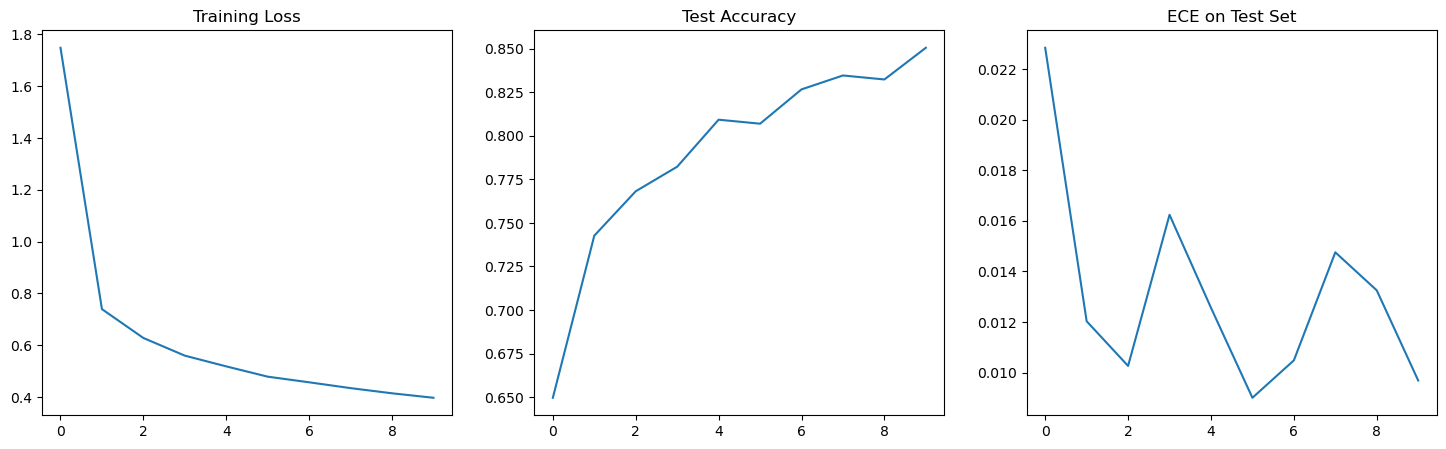

In [7]:
if train_deterministic:
    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.subplot(1,3,2)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(1,3,3)
    plt.plot(ece_list)
    plt.title("ECE on Test Set")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "deterministic lenet.jpg")

In [8]:
# ===================================================== #
# =  migrate from base model, finetune and train flow = #
# ===================================================== #

# parameters for base distribution 
NormalParams = lambda scale: {"loc":1.0, "scale":scale}
# flow configurations, List of tuple (type, depth, params)
AffineLayer = [("affine", 1, {"learnable":True})]
GlowStep =  lambda depth, width:[
            ("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
            ("planar2d", 1, {"init_sigma":0.01}),# the second stack of flows (type, depth, params)
            ("flowstep", depth, {"width":width,"keepdim":True}),
            ("planar2d", 1, {"init_sigma":0.01})] 
Planar1d = lambda depth: [("affine", 1), 
            ("planar", depth),
            ("element", 1, {"act":"tanh"})]
# stochastic part for a layer, base distribution name, distribution parameters, flow config 
NormalAffine = ("normal", NormalParams(0.5), AffineLayer)
NormalGlowStep = ("normal", NormalParams(0.5), GlowStep(2, 10))
NormalPlanar1d = ("normal", NormalParams(0.5), Planar1d(2))
# flow config for all layers in the model  
sto_model_cfg = [NormalAffine, NormalGlowStep, NormalAffine, NormalPlanar1d, NormalAffine]

In [9]:
def train_sto_lenet(sto_model_cfg, base_model):
    sto_model = StoLeNet(sto_cfg=sto_model_cfg).to(device)

    if train_deterministic:
        sto_model.migrate_from_det_model(base_model)

    det_params, sto_params = sto_model.det_and_sto_params()
    optimizer = optim.Adam([
                    {'params': det_params, 'lr': 2e-4},
                    {'params': sto_params, 'lr': 2e-3}
                ])

    num_epochs = 30
    loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
    for epoch in range(num_epochs):
        sto_model.train()
        batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = sto_model(img)
            log_likelihood, kl = sto_model.calc_loss(pred, label)
            loss = -log_likelihood + kl / len(trainloader.dataset)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_ll.append(log_likelihood.item()) 
            batch_kl.append(kl.item()/ len(trainloader.dataset))
        avg = lambda l: sum(l)/len(l)
        avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
        sto_acc = compute_accuracy(sto_model, testloader)
        sto_ece = compute_ece_loss(sto_model, testloader)
        print("Sto Model Epoch {} Avg Loss {:.4f} Likelihood {:.4f} KL {:.4f} Acc {:.4f} ECE {:.4f}".format(
                            epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
        loss_list.append(avg_loss)
        ll_list.append(avg_ll)
        kl_list.append(avg_kl)
        acc_list.append(sto_acc)
        ece_list.append(sto_ece)

    return sto_model, loss_list, ll_list, kl_list, acc_list, ece_list
    
results = train_sto_lenet(sto_model_cfg, base_model)

Sto Model Epoch 0 Avg Loss 0.7181 Likelihood -0.7157 KL 0.0024 Acc 0.8292 ECE 0.0628
Sto Model Epoch 1 Avg Loss 0.5174 Likelihood -0.5139 KL 0.0035 Acc 0.8431 ECE 0.0357
Sto Model Epoch 2 Avg Loss 0.4600 Likelihood -0.4556 KL 0.0044 Acc 0.8549 ECE 0.0446
Sto Model Epoch 3 Avg Loss 0.4221 Likelihood -0.4170 KL 0.0051 Acc 0.8637 ECE 0.0359
Sto Model Epoch 4 Avg Loss 0.3964 Likelihood -0.3906 KL 0.0058 Acc 0.8627 ECE 0.0227
Sto Model Epoch 5 Avg Loss 0.3748 Likelihood -0.3684 KL 0.0064 Acc 0.8689 ECE 0.0272
Sto Model Epoch 6 Avg Loss 0.3559 Likelihood -0.3491 KL 0.0068 Acc 0.8747 ECE 0.0219
Sto Model Epoch 7 Avg Loss 0.3383 Likelihood -0.3312 KL 0.0072 Acc 0.8774 ECE 0.0069
Sto Model Epoch 8 Avg Loss 0.3251 Likelihood -0.3176 KL 0.0075 Acc 0.8803 ECE 0.0089
Sto Model Epoch 9 Avg Loss 0.3155 Likelihood -0.3078 KL 0.0078 Acc 0.8834 ECE 0.0059
Sto Model Epoch 10 Avg Loss 0.3057 Likelihood -0.2977 KL 0.0080 Acc 0.8826 ECE 0.0110
Sto Model Epoch 11 Avg Loss 0.2954 Likelihood -0.2871 KL 0.0083 

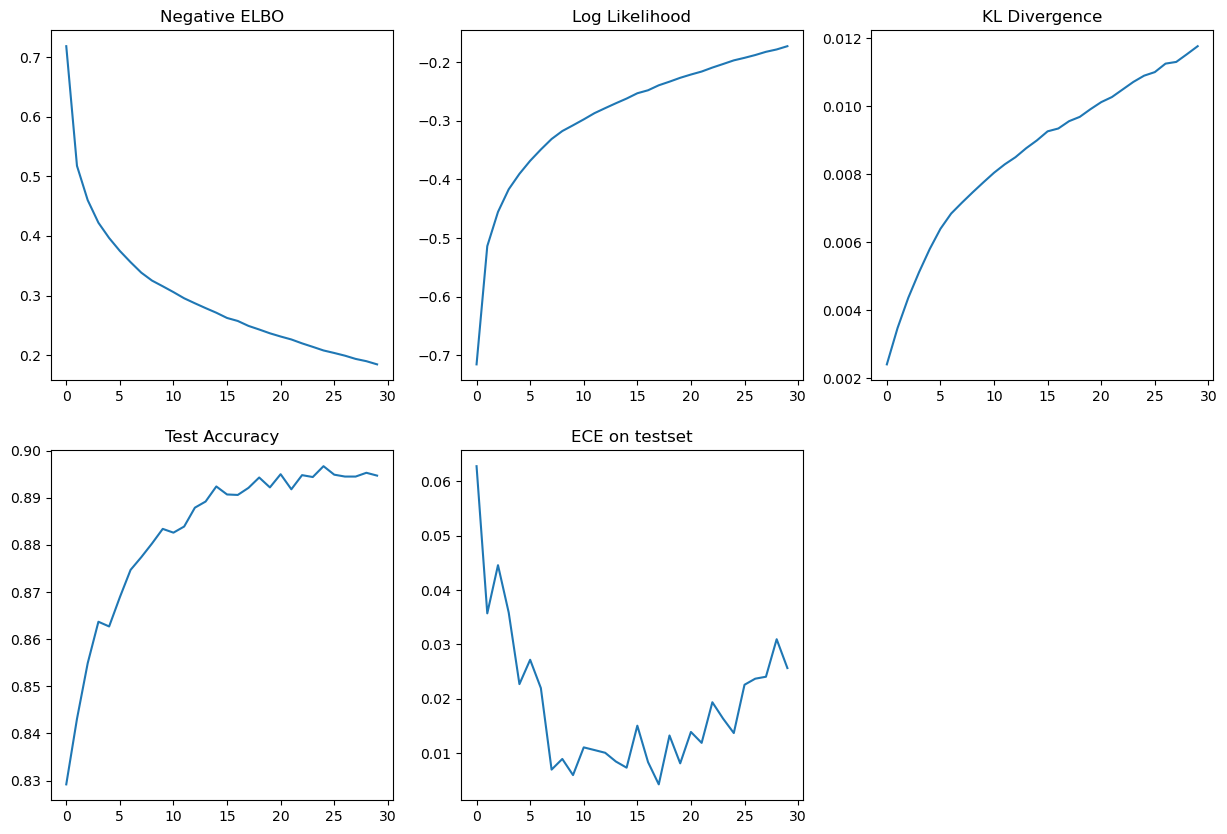

In [10]:
def plot_results(results, anno=""):
    sto_model, loss_list, ll_list, kl_list, acc_list, ece_list = results 
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    plt.plot(loss_list)
    plt.title("Negative ELBO")
    plt.subplot(2,3,2)
    plt.plot(ll_list)
    plt.title("Log Likelihood")
    plt.subplot(2,3,3)
    plt.plot(kl_list)
    plt.title("KL Divergence")
    plt.subplot(2,3,4)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(2,3,5)
    plt.plot(ece_list)
    plt.title("ECE on testset")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "stochastic_lenet_{}.jpg".format(anno))

plot_results(results, anno="full")

better results compared to last week (without the "step of flow" in Glow paper)

last time the ECE goes higher as training goes on, this time it's lower than the deterministic LeNet

should probably take the check point arount epoch 10~15, the model seems to overfit after about 20 epochs 

the accuracy increases (84% => 89%): model capacity has been increased by the stochastic part (some has a flow, others don't)

ece is slightly lower (0.01 => 0.004): model is better calibrated, so the flow helps 

if we remove all flows (only keep the base gaussian distribution together with an affine transformation)

the results is almost as good as the complicated model with flow. 

probably the best balanced results are (Acc 0.8903 ECE 0.0051), compared to the one with flow (0.8921 ECE 0.0042)

In [11]:
sto_model_cfg = [NormalAffine, NormalAffine, NormalAffine, NormalAffine, NormalAffine]
results = train_sto_lenet(sto_model_cfg, base_model)

Sto Model Epoch 0 Avg Loss 0.8318 Likelihood -0.8315 KL 0.0002 Acc 0.8132 ECE 0.1027
Sto Model Epoch 1 Avg Loss 0.6012 Likelihood -0.6004 KL 0.0008 Acc 0.8248 ECE 0.0594
Sto Model Epoch 2 Avg Loss 0.5312 Likelihood -0.5299 KL 0.0013 Acc 0.8411 ECE 0.0606
Sto Model Epoch 3 Avg Loss 0.4797 Likelihood -0.4780 KL 0.0017 Acc 0.8494 ECE 0.0563
Sto Model Epoch 4 Avg Loss 0.4487 Likelihood -0.4466 KL 0.0021 Acc 0.8531 ECE 0.0424
Sto Model Epoch 5 Avg Loss 0.4180 Likelihood -0.4156 KL 0.0024 Acc 0.8599 ECE 0.0294
Sto Model Epoch 6 Avg Loss 0.3962 Likelihood -0.3934 KL 0.0027 Acc 0.8650 ECE 0.0254
Sto Model Epoch 7 Avg Loss 0.3765 Likelihood -0.3735 KL 0.0030 Acc 0.8697 ECE 0.0331
Sto Model Epoch 8 Avg Loss 0.3636 Likelihood -0.3604 KL 0.0032 Acc 0.8736 ECE 0.0261
Sto Model Epoch 9 Avg Loss 0.3486 Likelihood -0.3451 KL 0.0035 Acc 0.8746 ECE 0.0231
Sto Model Epoch 10 Avg Loss 0.3338 Likelihood -0.3302 KL 0.0037 Acc 0.8752 ECE 0.0156
Sto Model Epoch 11 Avg Loss 0.3239 Likelihood -0.3201 KL 0.0039 

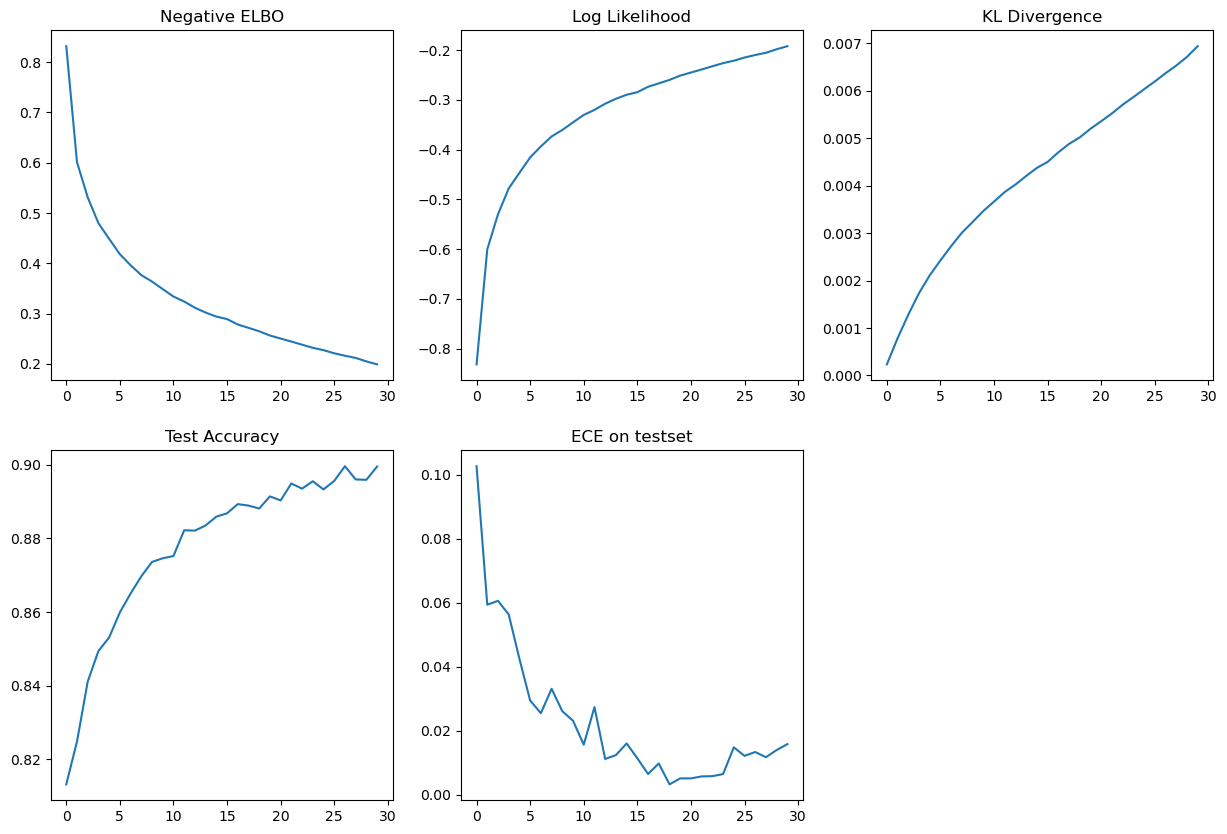

In [12]:
plot_results(results, anno="no_flow")